In [1]:
import pandas as pd
import numpy as np
from trails.read_data import get_obs_state_dct
import re
from trails.cutpoints import cutpoints_ABC, cutpoints_AB
from trails.optimizer import post_prob
%load_ext rpy2.ipython

n_sites = 200000

/Users/au595587/opt/miniconda3/envs/trails_plot/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ILS = 32

t_A = 200000/200
t_B = 200000/200
t_1 = max([t_A, t_B])
N_AB = 80000/200
t_2 = -N_AB*np.log(3/2*ILS/100)
t_C = t_1+t_2
N_ABC = 70000/200
t_3 = t_1*5
r = 0.5e-8*200
mu = 1.5e-8*200

# t_A = 1900
# t_B = 1900
# t_1 = max([t_A, t_B, t_C])
# N_AB = 500
# t_2 = t_1+t_2
# t_C = 1900
# N_ABC = 500
# t_3 = 8000
# r = 2e-6
# mu = 0.5e-6

n_int_AB = 5
n_int_ABC = 7

N_ref = N_ABC

t_out = t_1+t_2+t_3+2*N_ABC

coal_ABC = N_ref/N_ABC
coal_AB = N_ref/N_AB
t_upper = t_3-cutpoints_ABC(n_int_ABC, 1/N_ABC)[-2]
t_AB = t_2/N_ref

cut_AB = t_1+cutpoints_AB(n_int_AB, t_2, 1/N_AB)
cut_ABC = t_1+t_2+cutpoints_ABC(n_int_ABC, 1/N_ABC)

(2/3)*(np.exp(-t_2/(N_AB)))

cut_ABC

array([1293.58767003, 1347.54040797, 1411.35295285, 1489.45319581,
       1590.14192117, 1732.05470901, 1974.6562222 ,           inf])

## Plots

In [3]:
%%R

library(tidyverse)

hid_tab_second <- read_csv('../results/hid_tab_second.csv', show_col_types = FALSE)
tree_tab_second <- read_csv('../results/tree_tab_second.csv', show_col_types = FALSE)
post_tab_second <- read_csv('../results/post_tab_second.csv', show_col_types = FALSE)
hid_tab_first <- read_csv('../results/hid_tab_first.csv', show_col_types = FALSE)
tree_tab_first <- read_csv('../results/tree_tab_first.csv', show_col_types = FALSE)
post_tab_first <- read_csv('../results/post_tab_first.csv', show_col_types = FALSE)

post_tab_neutral <- read_csv('../../simulated_posterior/data/post_tab.csv', show_col_types = FALSE)
tree_tab_neutral <- read_csv('../../simulated_posterior/data/tree_tab.csv', show_col_types = FALSE)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [4]:
%%R -w 2000 -h 700 -r 150 -i n_int_AB

# p1 <- post_tab_first %>%
#     mutate(is_V0 = topology == 0) %>%
#     group_by(pos, is_V0, int_1) %>%
#     summarize(prob = sum(value)) %>%
#     ggplot() +
#     geom_tile(aes(pos, int_1+(!is_V0)*(n_int_AB+0.1), fill = prob, color = prob)) +
#     geom_segment(aes(x = start, xend = end, y = int_1+(!(topology == 0))*(n_int_AB+0.1), yend = int_1+(!(topology == 0))*(n_int_AB+0.1)), 
#                  color = 'red',
#                  data = tree_tab_first) +
#     scale_fill_viridis_c(limits=c(0,1)) +
#     scale_color_viridis_c(limits=c(0,1)) +
#     scale_x_continuous(expand = c(0, 0)) +
#     scale_y_continuous(expand = c(0, 0)) +
#     labs(y = 'First coalescent', x = 'Position')
#     
# p1

NULL


`summarise()` has grouped output by 'pos'. You can override using the `.groups`
argument.


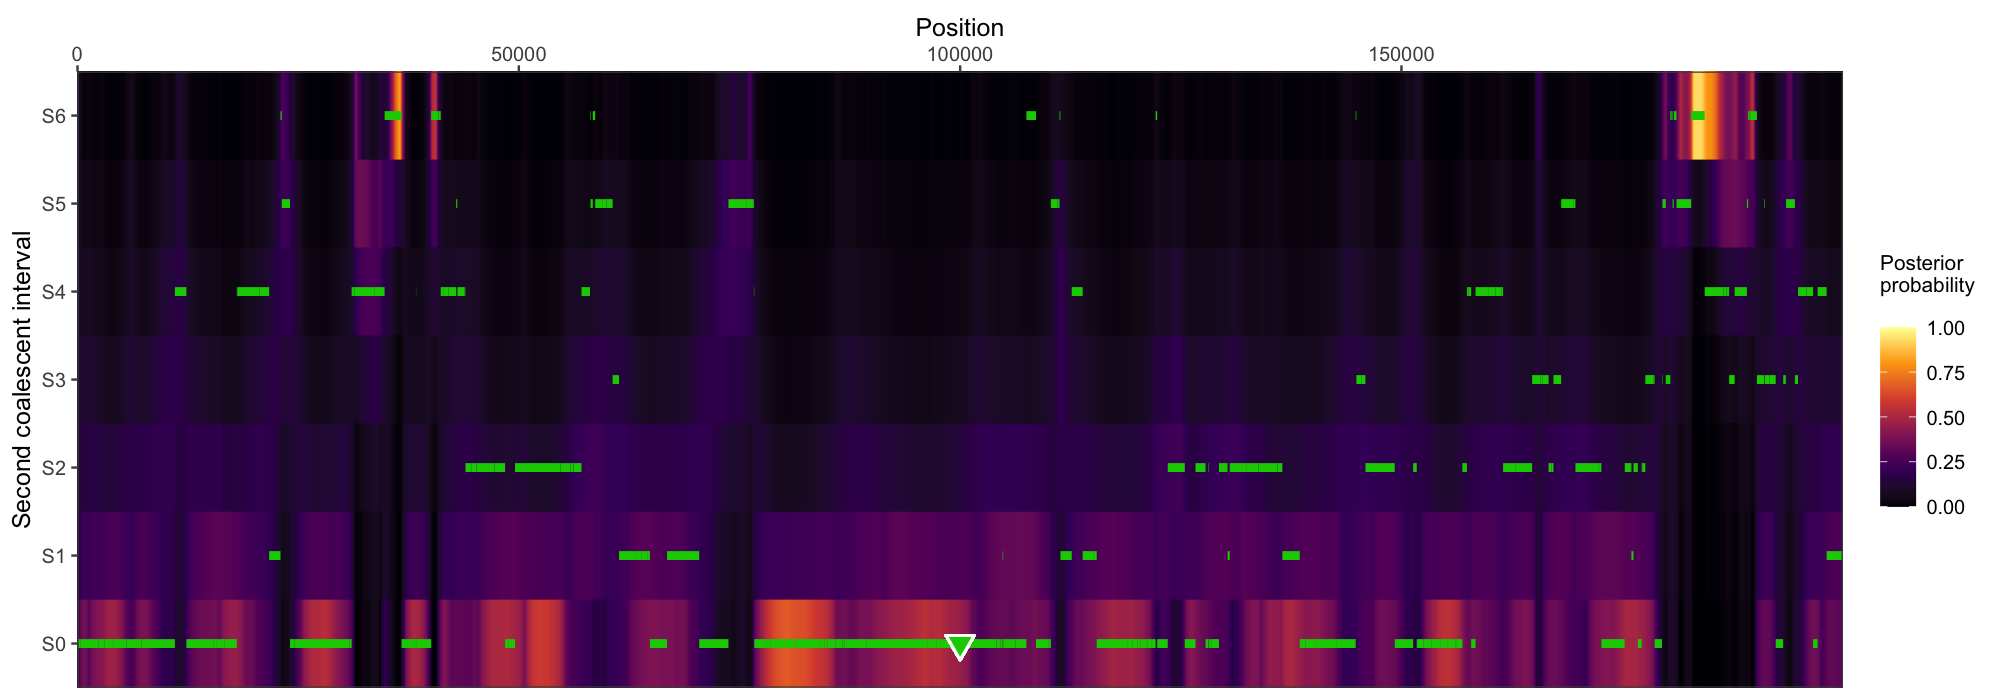

In [46]:
%%R -w 2000 -h 700 -r 150  -i n_int_AB -i n_int_ABC

library(ggthemes)

p2 <- post_tab_second %>%
    group_by(pos, int_2) %>%
    summarize(prob = sum(value)) %>%
    ggplot() +
    geom_tile(aes(pos, int_2, fill = prob, color = prob)) +
    geom_segment(aes(x = start, xend = end, y = int_2, yend = int_2), 
                 color = 'green3', size = 2,
                 data = tree_tab_second) +
    geom_point(aes(100000, 0), shape = 25, color = 'white', fill = 'green3', size = 4, stroke = 1) +
    scale_fill_viridis_c(
        name = 'Posterior\nprobability\n',
        limits=c(0,1), 
        option="inferno", 
        # trans = 'log'
        ) +
    scale_color_viridis_c(
        name = 'Posterior\nprobability\n',
        limits=c(0,1), 
        option="inferno", 
        # trans = 'log'
        ) +
    scale_x_continuous(expand = c(0, 0), position = "top") +
    scale_y_continuous(expand = c(0, 0),
                       breaks = 0:(n_int_ABC-1), 
                       labels = paste0('S', 0:(n_int_ABC-1))
                      ) +
    labs(y = 'Second coalescent interval', x = 'Position') +
    theme_few() +
    theme(legend.title = element_text(size = 10))

p2

In [6]:
%%R -w 2000 -h 700 -r 150

# p3 <- post_tab_second %>%
#     group_by(pos, topology) %>%
#     summarize(prob = sum(value)) %>%
#     ggplot() +
#     geom_tile(aes(pos, topology, fill = prob, color = prob)) +
#     geom_segment(aes(x = start, xend = end, y = topology, yend = topology), 
#                  color = 'red',
#                  data = tree_tab_second) +
#     scale_fill_viridis_c(limits=c(0,1)) +
#     scale_color_viridis_c(limits=c(0,1)) +
#     scale_x_continuous(expand = c(0, 0)) +
#     scale_y_continuous(expand = c(0, 0)) +
#     labs(y = 'Topology') +
#     theme(
#         axis.title.x = element_blank(),
#         axis.text.x = element_blank(),
#         axis.ticks.x=element_blank()
#     )
# 
# p3

NULL


In [7]:
%%R -i n_int_ABC -i n_sites

library(tidyverse)

# int_2_tab_true <- tibble()
# int_2_tab_post2 <- tibble()
# for (i in 10:29) {
#     print(i)
#     int_2_tab_post2 <- bind_rows(int_2_tab_post2, 
#         read_csv(paste0('../results/replicates/post_tab_second_', i,'.csv'), show_col_types = FALSE) %>% 
#         mutate(nsim = i) %>%
#         group_by(nsim, pos, int_2) %>%
#         summarize(prob = sum(value), .groups = 'drop') %>%
#         group_by(nsim, pos) %>%
#         filter(prob == max(prob)) %>%
#         group_by(nsim, int_2) %>%
#         summarize(
#             suma = n()/n_sites,
#             .groups = 'drop'
#         ) %>%
#         arrange(nsim, desc(int_2)) %>%
#         mutate(Type = 'Posterior max'))
#     int_2_tab_true <- bind_rows(int_2_tab_true, 
#         read_csv(paste0('../results/replicates/tree_tab_second_', i,'.csv'), show_col_types = FALSE) %>% 
#         mutate(nsim = i) %>%
#         group_by(nsim, int_2) %>%
#         summarize(
#             suma = sum(end-start)/n_sites, .groups = 'drop'
#         ) %>%
#         arrange(nsim, desc(int_2)) %>%
#         mutate(Type = 'Empirical'))
# }

# int_2_tab_post3 <- tibble()
# for (i in 10:15) {
#     print(i)
#     int_2_tab_post3 <- bind_rows(int_2_tab_post3, 
#         read_csv(paste0('../results/replicates/post_tab_second_', i,'.csv'), show_col_types = FALSE) %>% 
#         mutate(nsim = i) %>%
#         group_by(nsim, pos, int_2) %>%
#         summarize(prob = sum(value), .groups = 'drop') %>%
#         group_by(nsim, int_2) %>%
#         summarize(
#             suma = median(prob),
#             .groups = 'drop'
#         ) %>%
#         arrange(nsim, desc(int_2)) %>%
#         mutate(Type = 'Posterior max'))
# }
# write_csv(int_2_tab_post3, 'int_2_tab_post3.csv')

# int_2_tab_post4 <- tibble()
# for (i in 10:29) {
#     print(i)
#     int_2_tab_post4 <- bind_rows(int_2_tab_post4, 
#         read_csv(paste0('../results/replicates/post_tab_second_', i,'.csv'), show_col_types = FALSE) %>% 
#         mutate(nsim = i) %>%
#         group_by(nsim, pos, int_2) %>%
#         summarize(prob = sum(value), .groups = 'drop') %>%
#         group_by(nsim, int_2) %>%
#         summarize(
#             suma = mean(prob),
#             .groups = 'drop'
#         ) %>%
#         arrange(nsim, desc(int_2)) %>%
#         mutate(Type = 'Posterior max'))
# }
# write_csv(int_2_tab_post4, 'int_2_tab_post4.csv')


# write_csv(int_2_tab_true, 'int_2_tab_true.csv')
# write_csv(int_2_tab_post2, 'int_2_tab_post2.csv')

int_2_tab_true <- read_csv('int_2_tab_true.csv')
int_2_tab_post2 <- read_csv('int_2_tab_post4.csv')

Rows: 140 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Type
dbl (3): nsim, int_2, suma

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 140 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Type
dbl (3): nsim, int_2, suma

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [8]:
%%R -i n_int_ABC -i n_sites

int_2_tab_theo <- tibble(
    int_2 = 0:(n_int_ABC-1),
    suma = 1/n_int_ABC,
    Type = 'Theoretical'
)

summary_table <- bind_rows(
    int_2_tab_true, 
    int_2_tab_post2 
    ) %>% 
    mutate(
        Type = ifelse(Type == 'Posterior max', 'Mean posterior probability', Type),
        Type = ifelse(Type == 'Empirical', 'Empirical proportion', Type)
        ) %>%
    group_by(int_2, Type) %>%
    summarize(m = mean(suma))


`summarise()` has grouped output by 'int_2'. You can override using the
`.groups` argument.


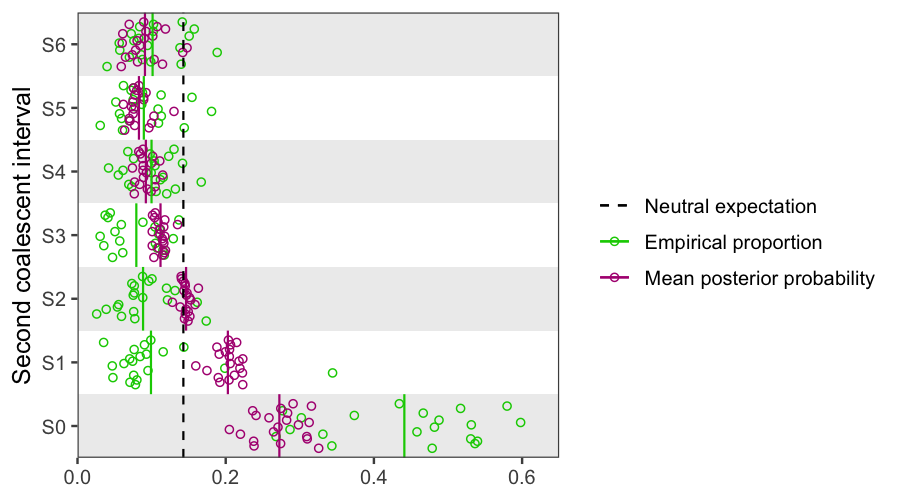

In [42]:
%%R -w 900 -h 500 -r 150 

library(ggthemes)

plot_post_binned <- bind_rows(
    # int_2_tab_post, 
    int_2_tab_true, 
    int_2_tab_post2, 
    # int_2_tab_theo
    ) %>%
    mutate(
        Type = ifelse(Type == 'Posterior max', 'Mean posterior probability', Type),
        Type = ifelse(Type == 'Empirical', 'Empirical proportion', Type),
        Type = factor(Type, (c('Empirical proportion', 'Mean posterior probability')))
        ) %>% 
    ggplot() +
    # geom_vline(aes(xintercept = x), data = tibble(x = 0:n_int_ABC), color = 'grey80') +
    geom_rect(aes(xmin = xmin, xmax = xmax, ymin = -Inf, ymax = Inf), 
              data = tibble(xmin = seq(0, n_int_ABC, 2), xmax = seq(1, n_int_ABC, 2)), fill = 'grey93') +
    # geom_col(aes(int_2, suma, fill = Type), position = 'dodge', color = 'black', width = 0.7) +
    geom_point(aes(int_2+((nsim-10)/20-0)/(0.95-0)*(0.85-0.15)+0.15, suma, color = Type), shape = 21) +
    geom_segment(aes(x = int_2, xend = int_2+1, y= m, yend = m, color = Type), data = summary_table) +
    geom_hline(aes(yintercept = 1/n_int_ABC, color = 'Neutral expectation'), linetype = 2) +
    # geom_segment(aes(x = int_2+(Type=='Empirical')*1/3+1/3, 
    #                  xend = int_2+(Type=='Empirical')*1/3+1/3, 
    #                  y = 0, yend = suma, color = Type)) +
    theme_few() +
    labs(x = 'Second coalescent interval', y = 'Proportion') +
    # scale_x_continuous(
    #     # breaks = 0:(n_int_ABC-1), 
    #     expand = c(0, 0),
    #     limits = c(0, n_int_ABC),
    #     breaks = 0:n_int_ABC
    # ) +
    scale_x_continuous(
        expand = c(0, 0),
        breaks = 0:(n_int_ABC-1)+0.5, 
        labels = paste0('S', 0:(n_int_ABC-1))) +
    scale_y_continuous(
        expand = c(0, 0),
        limits = c(0, 0.65)
    ) +
    scale_color_manual(
        name = 'Type',
        values = c('black', 'green3', '#b01e81'), 
        breaks = c('Neutral expectation', 'Empirical proportion', 'Mean posterior probability')) +
    theme(
        # axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        # legend.position = 'bottom',
        # axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        legend.title = element_blank(),
        # legend.position = c(0.8, 0.85),
        legend.background = element_blank(),
        legend.key = element_blank()
    ) +
    coord_flip()+
    guides(color = guide_legend(override.aes = list(linetype = c(2, 1, 1), shape = c(NA, 21, 21)) ) )
    
plot_post_binned

In [10]:
%%R

int_2_tab_true_bis <- read_csv('../../simulated_posterior/analyses/int_2_tab_true.csv')
int_2_tab_post2_bis <- read_csv('../../simulated_posterior/analyses/int_2_tab_post4.csv')

summary_table_bis <- bind_rows(
    int_2_tab_true_bis, 
    int_2_tab_post2_bis
    ) %>% 
    mutate( 
        Type = ifelse(Type == 'Posterior max', 'Mean posterior probability', Type),
        Type = ifelse(Type == 'Empirical', 'Empirical proportion', Type)
        ) %>%
    group_by(int_2, Type) %>%
    summarize(m = mean(suma))

Rows: 140 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Type
dbl (3): nsim, int_2, suma

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 160 Columns: 4
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (1): Type
dbl (3): nsim, int_2, suma

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
`summarise()` has grouped output by 'int_2'. You can override using the
`.groups` argument.


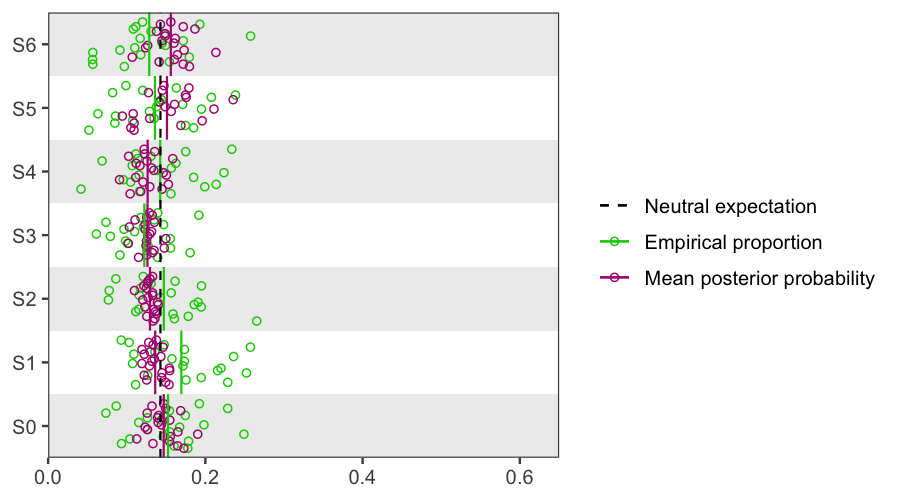

In [35]:
%%R -w 900 -h 500 -r 150 

library(ggthemes)

plot_post_binned_bis <- bind_rows(
    # int_2_tab_post, 
    int_2_tab_true_bis, 
    int_2_tab_post2_bis, 
    # int_2_tab_theo
    ) %>%
    mutate(
        Type = ifelse(Type == 'Posterior max', 'Mean posterior probability', Type),
        Type = ifelse(Type == 'Empirical', 'Empirical proportion', Type),
        Type = factor(Type, (c('Empirical proportion', 'Mean posterior probability')))
        ) %>% 
    ggplot() +
    # geom_vline(aes(xintercept = x), data = tibble(x = 0:n_int_ABC), color = 'grey80') +
    geom_rect(aes(xmin = xmin, xmax = xmax, ymin = -Inf, ymax = Inf), 
              data = tibble(xmin = seq(0, n_int_ABC, 2), xmax = seq(1, n_int_ABC, 2)), fill = 'grey93') +
    # geom_col(aes(int_2, suma, fill = Type), position = 'dodge', color = 'black', width = 0.7) +
    geom_point(aes(int_2+((nsim-10)/20-0)/(0.95-0)*(0.85-0.15)+0.15, suma, color = Type), shape = 21) +
    geom_segment(aes(x = int_2, xend = int_2+1, y= m, yend = m, color = Type), data = summary_table_bis) +
    geom_hline(aes(yintercept = 1/n_int_ABC, color = 'Neutral expectation'), linetype = 2) +
    # geom_segment(aes(x = int_2+(Type=='Empirical')*1/3+1/3, 
    #                  xend = int_2+(Type=='Empirical')*1/3+1/3, 
    #                  y = 0, yend = suma, color = Type)) +
    theme_few() +
    labs(x = 'Second coalescent', y = 'Proportion') +
    scale_x_continuous(
        expand = c(0, 0),
        breaks = 0:(n_int_ABC-1)+0.5, 
        labels = paste0('S', 0:(n_int_ABC-1))) +
    scale_y_continuous(
        expand = c(0, 0),
        limits = c(0, 0.65)
    ) +
    scale_color_manual(
        name = 'Type',
        values = c('black', 'green3', '#b01e81'), 
        breaks = c('Neutral expectation', 'Empirical proportion', 'Mean posterior probability')) +
    theme(
        axis.title.y = element_blank(),
        axis.title.x = element_blank(),
        # axis.text.y = element_blank(),
        # axis.ticks.y = element_blank(),
        legend.title = element_blank(),
        # legend.position = c(0.8, 0.85),
        legend.background = element_blank(),
        legend.key = element_blank()
    ) +
    coord_flip()+
    guides(color = guide_legend(override.aes = list(linetype = c(2, 1, 1), shape = c(NA, 21, 21)) ) )
    
plot_post_binned_bis

In [48]:
%%R -w 2000 -h 1000 -r 150 

library(patchwork)

# (p2 / ((plot_post_binned | plot_post_binned_bis) + plot_layout(guides = 'collect')))

p3 <- ((plot_post_binned | plot_post_binned_bis) + plot_layout(guides = 'collect')) & 
scale_color_manual(
    name = 'Type',
    values = c('black', 'green3', '#b01e81'), 
    breaks = c('Neutral expectation', 'Empirical proportion', 'Mean posterior probability'),
    labels = c('\nNeutral\nexpectation\n', '\nEmpirical\nproportion\n', '\nMean posterior\nprobability\n')) 

(p2 / p3) + plot_annotation(tag_levels = 'A')

ggsave(paste0('../plots/posterior_decoding_selection_replicates_new.tiff'), width = 14, height = 14/2)
# ggsave(paste0('../plots/posterior_decoding_selection.pdf'), width = 14, height = 14/4)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


In [39]:
%%R -w 2000 -h 500 -r 150 



Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
